100%|██████████| 90/90 [00:00<00:00, 195.89it/s]


Number of classes,  4


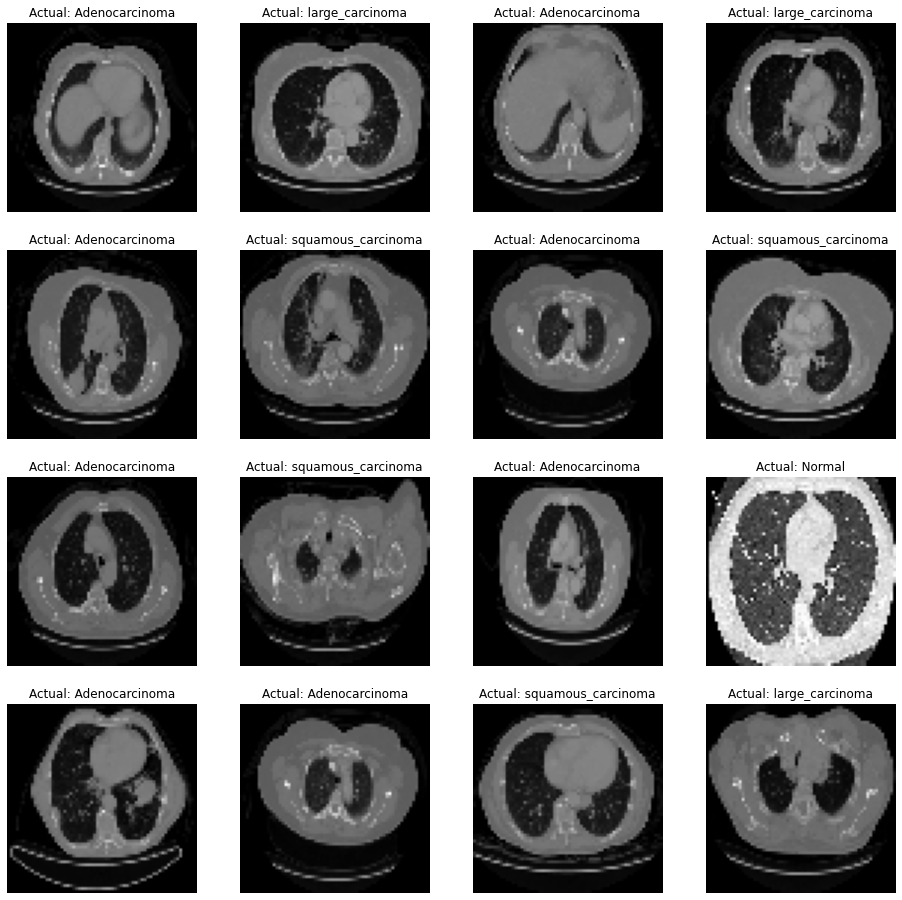

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Model
from tqdm import tqdm
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks

classes = {'Normal': 0, 'Adenocarcinoma': 1, 'large_carcinoma': 2, 'squamous_carcinoma': 3}

Normal=r'test/normal'
Adenocarcinoma=r'test/adenocarcinoma'
Large_carcinoma=r'test/large.cell.carcinoma'
Squamous_carcinoma=r'test/squamous.cell.carcinoma'


IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE=64
N_CLASSES = 4
EPOCHS = 50

def assign_label(img,class_type):
    return class_type

X = []
y = []

def make_train_data(class_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,class_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
        
        X.append(np.array(img))
        y.append(str(label))

make_train_data(classes.get('Normal'), Normal)

make_train_data(classes.get('Adenocarcinoma'), Adenocarcinoma)

make_train_data(classes.get('large_carcinoma'), Large_carcinoma)

make_train_data(classes.get('squamous_carcinoma'), Squamous_carcinoma)

len(X)
y = np.array(y)
X = np.array(X)
X.shape

X.shape, y.shape

from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=58954)

k = len(set(y_train))
print("Number of classes, ", k)

X_train = X_train.astype('float64')/255
X_test = X_test.astype('float64')/255

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

labels = '''Normal
Adenocarcinoma
large_carcinoma
squamous_carcinoma
'''.split("\n")

plt.figure(figsize=(16,16))
j = 1
for i in np.random.randint(0,283,16):
    plt.subplot(4,4,j); j+=1
    plt.imshow(X_train[i],cmap = 'Greys')
    plt.axis('off')
    plt.title("Actual: {}".format(labels[np.argmax(y_train[i])]))
    #plt.title('{} / {}'.format(labels[y_train[i]],y_train[i]))



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 32)          18464     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               524544    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0   

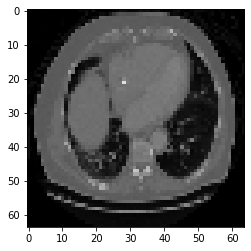

In [9]:
i = layers.Input(shape = (X_train[0].shape))
x = layers.Conv2D(64, (3,3), activation="relu", strides=(2,2), padding="same" )(i)
x = layers.Conv2D(64, (3,3), activation="relu", strides=(2,2), padding="same" )(x)
x = layers.Conv2D(32, (3,3), activation="relu", strides=(2,2), padding="same" )(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(k, activation='softmax')(x)

#Construction du modèle:
model = Model(i, x)

model.summary()
#Compilation du modèle :
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=3, min_lr=0.00001)

model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=  (X_test,y_test), callbacks=[reduce_lr])

print("The class of this is: {}".format(np.argmax(y_train[10])))
plt.imshow(X_train[10], cmap='gray')
plt.show()